### Cab-Driver Agent

In [33]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [34]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [35]:
track_state_0_9_1_act_0_2 = []

track_state_4_1_4_act_3_0 = []

track_state_1_14_6_act_4_1 = []

states_tracked = {'0_9_1_0_2':[], '4_1_4_3_0':[], '1_14_6_4_1':[]}

In [36]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [37]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01      
        self.epsilon_max = 1
        self.epsilon = 0
        self.epsilon_decay = 0.0005
        self.epsilon_min = 0.00001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets        
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        possible_actions_index,actions = env.requests(state)
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch2(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            
            return possible_actions_index[np.argmax(q_vals_possible)]
        
    

    def append_sample(self, state, action_idx, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_idx, reward, next_state, done))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            actions, rewards = [], []
            done_arr = []
            
            # Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                state, action_idx, reward, next_state, done = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)
                update_output[i] = env.state_encod_arch2(next_state)
                actions.append(action_idx)
                rewards.append(reward)
                done_arr.append(done)
        else:
            return
            
        #Predict the target from earlier model
        target = self.model.predict(update_input)
            
        #Get the target for the Q-network
        target_val = self.model.predict(update_output)
        
        #update target vals
        for i in range(self.batch_size):
            if done_arr[i]:
                target[i][actions[i]] = rewards[i]
            else: # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_val[i])
      
                
        # 4. Fit your model and track the loss values
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save_weights(name)

In [38]:
Episodes = 20000

max_episode_time = 24*30

total_reward = 0
avg_rewards_arr = []

### DQN block

In [39]:
#start_time = time.time()
agent = DQNAgent(action_size=21, state_size=36)
for episode in range(Episodes):
    
    #print('episode:',episode)

    # Write code here
    terminal_state = False
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()
    
    episode_time = 0
    
    ride_count = 0
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        #possible_actions_indices, actions = env.requests(state)
        action_idx = agent.get_action(state)
        action = env.action_space[action_idx]
        
        #if (state == [0,9,1]):
        #    print('Saw reqd condn')
            
        # 2. Evaluate your reward and next state
        next_state, reward, step_time = env.step(state, action, Time_matrix)
        #print(f'pres_state:{state} and next_state:{next_state} and step_time:{step_time}')
        
        episode_time = episode_time + step_time
        
        #print('episode_time:',episode_time)
        
        if(episode_time >= max_episode_time):
            terminal_state = True
        # 3. Append the experience to the memory
        agent.append_sample(state, action_idx, reward, next_state, terminal_state)
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        #print('reward:',reward)
        total_reward = total_reward + reward
        
        #print('reward_per_episode:',reward_per_episode)
        
        ride_count = ride_count + 1
        
        state = next_state
        
    #print('ride_count:',ride_count)    
    
    
    # epsilon decay
    #agent.epsilon = (1 - 0.00001) * np.exp(-1*agent.epsilon_decay * episode)
    agent.epsilon = 1 * np.exp(-1*agent.epsilon_decay * episode)
    
    if ((episode + 1) % 10 == 0):
        print("episode {0}, avg_reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode+1,
                                                                         total_reward/10,
                                                                         len(agent.memory),
                                                                         agent.epsilon, episode_time))
        track_state = np.array(env.state_encod_arch2([0,9,1])).reshape(1, 36)
        q_value = agent.model.predict(track_state)
        track_state_0_9_1_act_0_2.append(q_value[0][env.action_space.index([0,2])])
        
        track_state = np.array(env.state_encod_arch2([4,1,4])).reshape(1, 36)
        q_value = agent.model.predict(track_state)
        track_state_4_1_4_act_3_0.append(q_value[0][env.action_space.index([3,0])])
        
        track_state = np.array(env.state_encod_arch2([1,14,6])).reshape(1, 36)
        q_value = agent.model.predict(track_state)
        track_state_1_14_6_act_4_1.append(q_value[0][env.action_space.index([4,1])])
        
        states_tracked['0_9_1_0_2'] = track_state_0_9_1_act_0_2
        states_tracked['4_1_4_3_0'] = track_state_4_1_4_act_3_0
        states_tracked['1_14_6_4_1'] = track_state_1_14_6_act_4_1
        
        save_obj(states_tracked, 'states_tracked')
        
        avg_rewards_arr.append(total_reward/10)
        #clear it so that again avg rewards can be calculated
        total_reward = 0

        save_obj(avg_rewards_arr, 'avg_rewards_tracked')
        
    if((episode + 1) % 100 == 0):
        print('Saving model weights for episode:{}'.format(episode+1))
        agent.save('model_weights_{}.h5'.format(episode+1))
        

episode 10, avg_reward -96.2, memory_length 1362, epsilon 0.9955101098295706 total_time 724.0
episode 20, avg_reward -229.3, memory_length 2000, epsilon 0.9905449824429005 total_time 720.0
episode 30, avg_reward -187.7, memory_length 2000, epsilon 0.9856046187323824 total_time 726.0
episode 40, avg_reward -234.3, memory_length 2000, epsilon 0.9806888951886662 total_time 728.0
episode 50, avg_reward -150.0, memory_length 2000, epsilon 0.9757976889184073 total_time 723.0
episode 60, avg_reward -180.5, memory_length 2000, epsilon 0.9709308776411942 total_time 724.0
episode 70, avg_reward -244.1, memory_length 2000, epsilon 0.9660883396864915 total_time 723.0
episode 80, avg_reward -192.8, memory_length 2000, epsilon 0.9612699539905982 total_time 720.0
episode 90, avg_reward -237.7, memory_length 2000, epsilon 0.9564756000936208 total_time 721.0
episode 100, avg_reward -113.7, memory_length 2000, epsilon 0.9517051581364622 total_time 723.0
Saving model weights for episode:100
episode 110, 

### Tracking Convergence

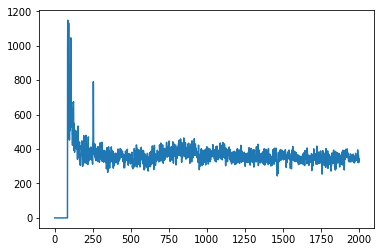

In [40]:
import matplotlib.pyplot as plt
plt.plot(track_state_0_9_1_act_0_2)

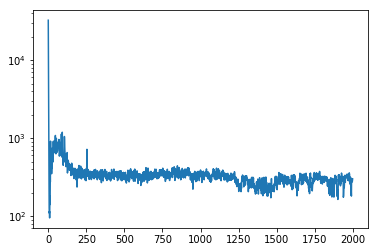

In [44]:
plt.plot(track_state_4_1_4_act_3_0)
plt.yscale('log')

## Tracking Rewards

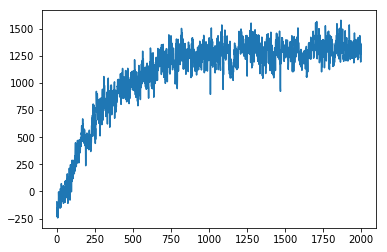

In [43]:
plt.plot(avg_rewards_arr)

#### After 10000 episodes there seems to be not much learning